In [34]:
import numpy as np
import wfdb

def standardize_ecg(ecg_data, file_name):
    # Normalizar los valores de voltaje a un rango de 0 a 1
    ecg_data_normalized = (ecg_data - np.min(ecg_data)) / (np.max(ecg_data) - np.min(ecg_data))
    
    # Asegurarse de que todos los ECGs tengan la misma frecuencia de muestreo
    # Aquí puedes definir la frecuencia de muestreo deseada
    target_sampling_rate = 500  # Ejemplo de frecuencia de muestreo deseada en Hz
    
    # Si el archivo tiene una frecuencia de muestreo diferente, usar interpolación
    record = wfdb.rdsamp(file_name)
    original_sampling_rate = record[1]['fs']
    
    if original_sampling_rate != target_sampling_rate:
        num_samples = int(len(ecg_data_normalized) * target_sampling_rate / original_sampling_rate)
        # Interpolación de los datos normalizados
        x_old = np.linspace(0, len(ecg_data_normalized), len(ecg_data_normalized))
        x_new = np.linspace(0, len(ecg_data_normalized), num_samples)
        ecg_data_standardized = np.interp(x_new, x_old, ecg_data_normalized)
    else:
        ecg_data_standardized = ecg_data_normalized

    return ecg_data_standardized

In [35]:
import wfdb
import numpy as np
import os

directory = "./data/"
ECGs = []
lista = os.listdir(directory)
sorted_files = sorted(lista, key=lambda x: int(x.split('.')[0]))
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
            ECGs.append(standardized_ecg) 
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGs = np.asarray(ECGs)
print(len(ECGs))


200


In [36]:
import wfdb
import numpy as np
import os

directoryAtletas = "./datos/"
ECGsAtletas = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directoryAtletas + ecgfilename.split(".")[0])
            standardized_ecg_atleta = standardize_ecg(ecg[0], directoryAtletas + ecgfilename.split(".")[0])  # Estandarizar
            ECGsAtletas.append(standardized_ecg_atleta) 
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGsAtletas = np.asarray(ECGsAtletas)
print(len(ECGsAtletas))

28


In [37]:
#etiquetas a considerar
#Clasificar los ECGs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Leer las etiquetas de los ECGs, sin repetir
etiquetasConsiderar = []
etiquestasCardiologosAtletas = []
etiquetaRiesgoDeportista = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    # Solo leer los archivos .hea desde el ath_001 hasta el ath_019
    if ecgfilename.endswith(".hea"):
        with open(directoryAtletas + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                riesgos = 0
                if line.startswith("#C:"):
                    etiqueta = line.split(":")[1].strip()
                    etiquetas = etiqueta.split(", ")
                    for etiqueta in etiquetas:
                        etiqueta = etiqueta.lower()
                        if etiqueta not in etiquetasConsiderar:
                            etiquetasConsiderar.append(etiqueta)
                        diagnoses.append(etiqueta)
                        if(etiqueta == "right axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left atrial enlargement"):
                            riesgos += 1

                    etiquestasCardiologosAtletas.append(diagnoses)
                    if(riesgos >= 1):
                        etiquetaRiesgoDeportista.append("borderline ecg")
                    else:
                        etiquetaRiesgoDeportista.append("normal ecg")

#impriir las etiquetas
print(etiquetasConsiderar)

#imprimir las etiquetas de los atletas
for i in range(len(etiquestasCardiologosAtletas)):
    print(f"Etiquetas del atleta {i + 1}: {etiquestasCardiologosAtletas[i]}")

print(etiquetaRiesgoDeportista)



['sinus arrhythmia', 'normal ecg', 'right axis deviation', 'normal sinus rhythm', 'left axis deviation', 'borderline ecg', 'sinus bradycardia', 'first degree av block', 'left ventricular hypertrophy', 'incomplete right bundle branch block', 'possible left ventricular hypertrophy', 'left atrial enlargement', 'misplaced electrodes']
Etiquetas del atleta 1: ['sinus arrhythmia', 'normal ecg']
Etiquetas del atleta 2: ['sinus arrhythmia', 'right axis deviation', 'normal ecg']
Etiquetas del atleta 3: ['normal sinus rhythm', 'left axis deviation', 'borderline ecg']
Etiquetas del atleta 4: ['normal sinus rhythm', 'normal ecg']
Etiquetas del atleta 5: ['sinus bradycardia', 'normal sinus rhythm', 'first degree av block', 'normal ecg']
Etiquetas del atleta 6: ['normal sinus rhythm', 'left ventricular hypertrophy', 'normal ecg']
Etiquetas del atleta 7: ['normal sinus rhythm', 'normal ecg']
Etiquetas del atleta 8: ['normal sinus rhythm', 'incomplete right bundle branch block', 'normal ecg']
Etiqueta

In [38]:
#Filtrar datos para utilizar con la bd de deportistas
etiquestasCardiologos = []
ages = []
sexes = []
ECGsFiltrados = []
etiquetaRiesgo = []
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".hea"):
        with open(directory + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                line = line.lower()
                if line.startswith("#<age>:"):
                    #si la edad es mayor a 50 años no se considera
                    if int(line.split(":")[1].strip()) <= 45:
                        ages.append(line.split(":")[1].strip())
                        try:
                            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
                            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
                            ECGsFiltrados.append(standardized_ecg) 
                        except Exception as e:
                            print(f"Error al leer el archivo {ecgfilename}: {e}")
                    else:
                        break
                elif line.startswith("#<sex>:"):
                    sexes.append(line.split(":")[1].strip())
                #todas las linesa que esten despues de #<diagnoses> son las etiquetas de los cardiologos
                elif line.startswith("#<diagnoses>"):
                    riesgos = 0
                    for line in lines[lines.index("#<diagnoses>:\n")+1:]:
                        line = line.lower()
                        if line.startswith("#rhythm"):
                            #seleccionar solo despues del :
                            line = line.split(": ")[1].strip()                 
                            diagnoses.append(line.split(".")[0].lower())

                        elif line.startswith("#electric axis of the heart:"):
                            line = line.split(": ")[1].strip()
                            if line == "vertical." or line == "horizontal." or line == "normal.":
                                diagnoses.append("normal axis")
                            else:
                                diagnoses.append(line.split(".")[0].lower())
                                riesgos += 1
                        elif "degree" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                        elif "left ventricular" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                        elif "left atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                            riesgos += 1
                        elif "right bundle branch block" in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                            riesgos += 1
                        elif "right atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                            riesgos += 1
                        #else:
                            #diagnoses.append(line.split(".")[0].lower())            
                    etiquestasCardiologos.append(diagnoses)

                    if(riesgos >= 1):
                        etiquetaRiesgo.append("borderline ecg")
                    else:
                        etiquetaRiesgo.append("normal ecg")

                    

# Print parsed data
print(f"Ages: {ages}")
print(f"Sexes: {sexes}")

#cantidad de edades menores de 50 años
cantidadEdades = 0
for i in range(len(ages)):
    if int(ages[i]) <= 45:
        cantidadEdades += 1
print(f"La cantidad de edades menores a 45 años es: {cantidadEdades}")


#imprimir solo los que no tienen la eitqueta '#Rhythm: Sinus rhythm.'
for i in range(len(etiquestasCardiologos)):
    print(f"ECG {i} tiene las siguientes etiquetas: {etiquestasCardiologos[i]}")

print(etiquetaRiesgo)

print(len(ECGsFiltrados))
print(len(etiquetaRiesgo))
        


Ages: ['41', '30', '34', '34', '38', '27', '32', '45', '19', '41', '38', '41', '28', '44', '44', '40', '23', '26', '25', '18', '26', '26', '22', '19', '39', '43', '19', '15', '19', '26', '25', '35', '30', '27', '23', '22', '28', '23', '23', '20', '19', '30', '41', '20', '19', '20', '44', '35', '24', '39', '24', '18', '44', '34', '38', '11', '19', '42', '22', '17', '17', '19', '24', '42', '28', '28', '34', '38', '34']
Sexes: ['m', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'f', 'm', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'f', 'm', 'f', 'f', 'f', 'm', 'f', 'f', 'm', 'm', 'f', 'f', 'f', 'f', 'm', 'm', 'f', 'm', 'f', 'f', 'f', 'f']
La cantidad de edades menores a 45 años es: 69
ECG 0 tiene las siguientes etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 1 tiene las siguientes etiquetas: ['si

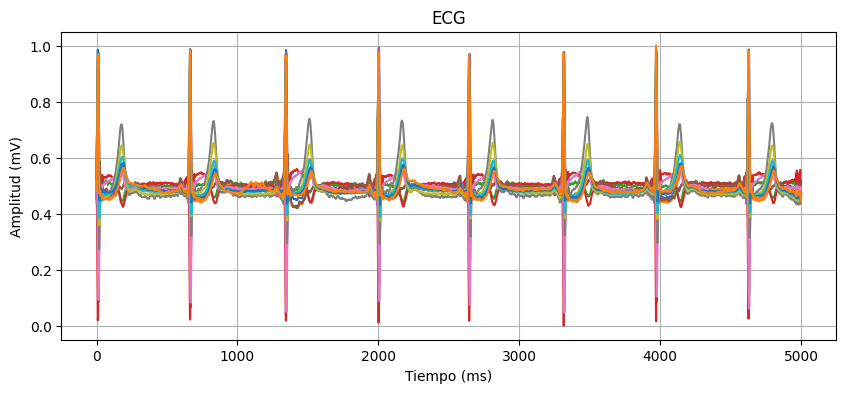

In [39]:
#grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(ECGs[0])
plt.title('ECG')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (mV)')
plt.grid()

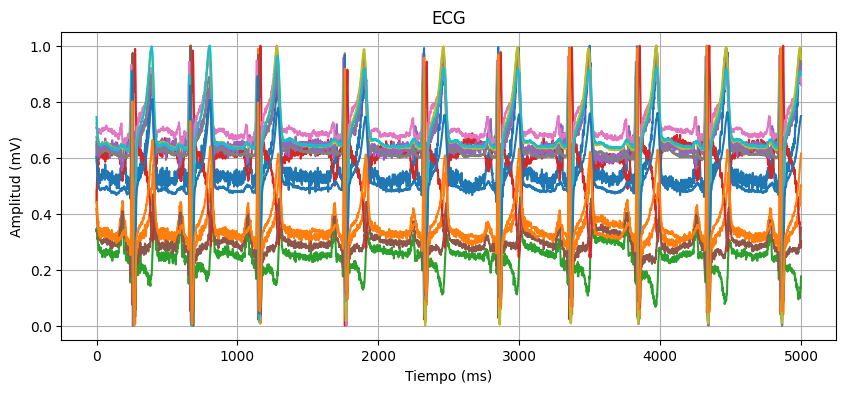

In [40]:
#grafico
import matplotlib.pyplot as plt2
plt2.figure(figsize=(10, 4))
plt2.plot(ECGsAtletas[0])
plt2.title('ECG')
plt2.xlabel('Tiempo (ms)')
plt2.ylabel('Amplitud (mV)')
plt2.grid()

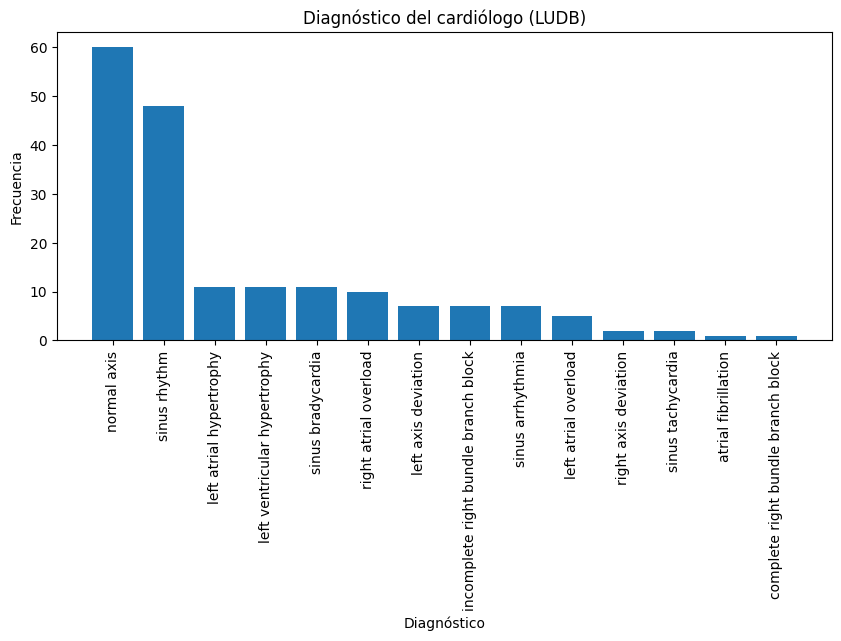

In [41]:
# Visualization as in your previous code
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the diagnoses list and count frequency of unique diagnoses
all_diagnoses = [item for sublist in etiquestasCardiologos for item in sublist]
counter = Counter(all_diagnoses)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

# Plot the most frequent diagnoses
plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.title('Diagnóstico del cardiólogo (LUDB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

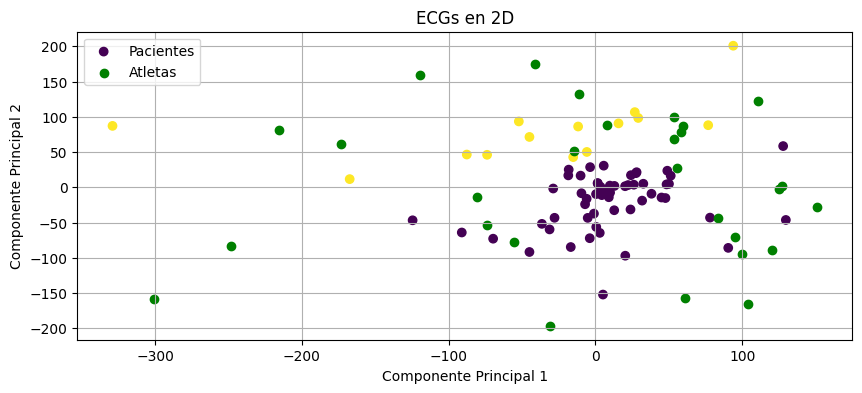

In [42]:

# Importar las librerías necesarias
#import matplotlib
#matplotlib.use('TkAgg')  # Forzar backend interactivo

#%pip install mplcursors

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import mplcursors
from sklearn.cluster import KMeans
import numpy as np
import numpy as np



# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Clasificar los ECGs por género
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Graficar los ECGs en 2D con los clusters
fig, ax = plt.subplots(figsize=(10, 4))
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs de los atletas por género
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Mostrar ambos datos juntos identificando de verde los atletas
scatterD = ax.scatter(principal_componentsD[:, 0], principal_componentsD[:, 1], c='green')

# Añadir etiquetas al pasar el cursor para los pacientes
cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"Etiqueta: {etiquetas[sel.index]}" + "\nEdad: " + str(ages[sel.index]) + "\nSexo: " + str(sexes[sel.index])))

# Añadir etiquetas para los atletas (puedes personalizar más esta etiqueta si es necesario)
cursorD = mplcursors.cursor(scatterD, hover=True)
cursorD.connect("add", lambda sel: sel.annotation.set_text("Atleta"))

# Añadir leyenda
ax.legend([scatter, scatterD], ['Pacientes', 'Atletas'])

# Mostrar la gráfica
plt.title('ECGs en 2D')


plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()


ECG 0 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 2 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'incomplete right bundle branch block']
ECG 6 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'right atrial overload', 'left atrial overload']
ECG 7 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'left axis deviation', 'incomplete right bundle branch block', 'left atrial hypertrophy']
ECG 8 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial overload']
ECG 9 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left ventricular hypertrophy']
ECG 10 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 11 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial hypertrophy']
ECG 12 es Borderline ECG
Etiquetas: ['sinus arrhythmia', '

<Figure size 1000x400 with 0 Axes>

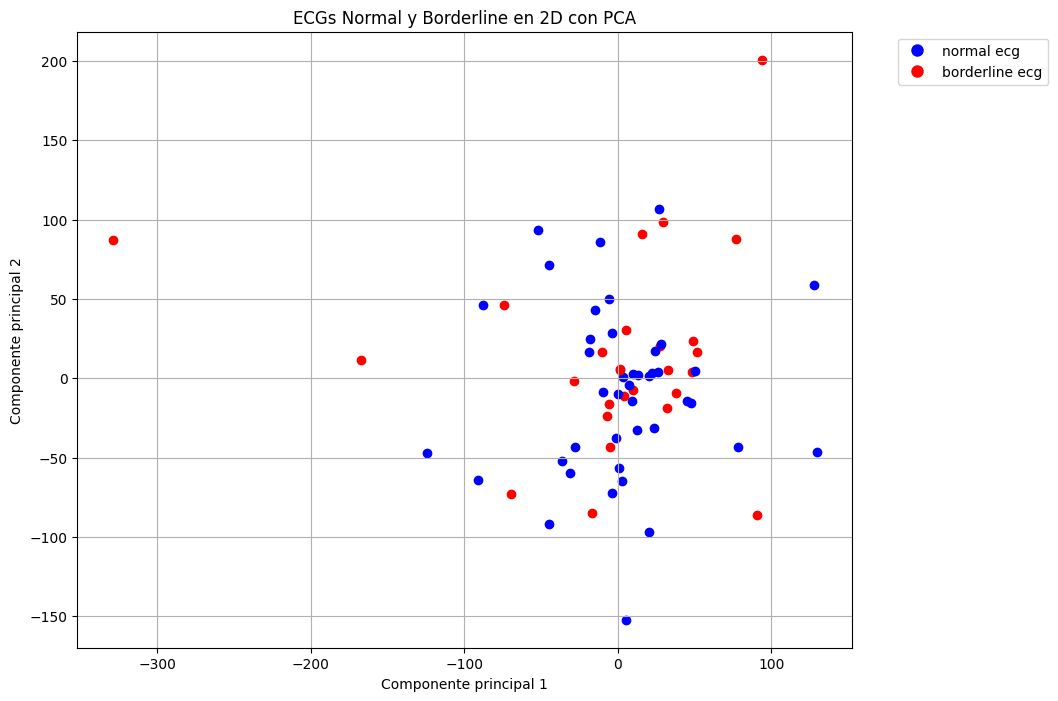

In [43]:
#graficar ECGs normal y borderline

#es normal si tiene la etiqueta 'Normal ECG'
#es borderline si tiene la etiqueta 'Borderline ECG'

# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 4))


# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))
# Crear un mapa de colores para las etiquetas
#azul para normal y naranja para borderline
label_color_map = {'normal ecg': 'blue', 'borderline ecg': 'red'}

# Graficar cada punto
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgo[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='blue', label='normal ecg' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='red', label='borderline ecg' if i == 0 else "")
        print(f"ECG {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologos[i]}")

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10) for label in label_color_map]
plt.legend(handles, label_color_map.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y Borderline en 2D con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()

69
200
ECG 0 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 2 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'incomplete right bundle branch block']
ECG 6 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'right atrial overload', 'left atrial overload']
ECG 7 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'left axis deviation', 'incomplete right bundle branch block', 'left atrial hypertrophy']
ECG 8 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial overload']
ECG 9 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left ventricular hypertrophy']
ECG 10 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 11 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial hypertrophy']
ECG 12 es Borderline ECG
Etiquetas: ['sinus arrhyth

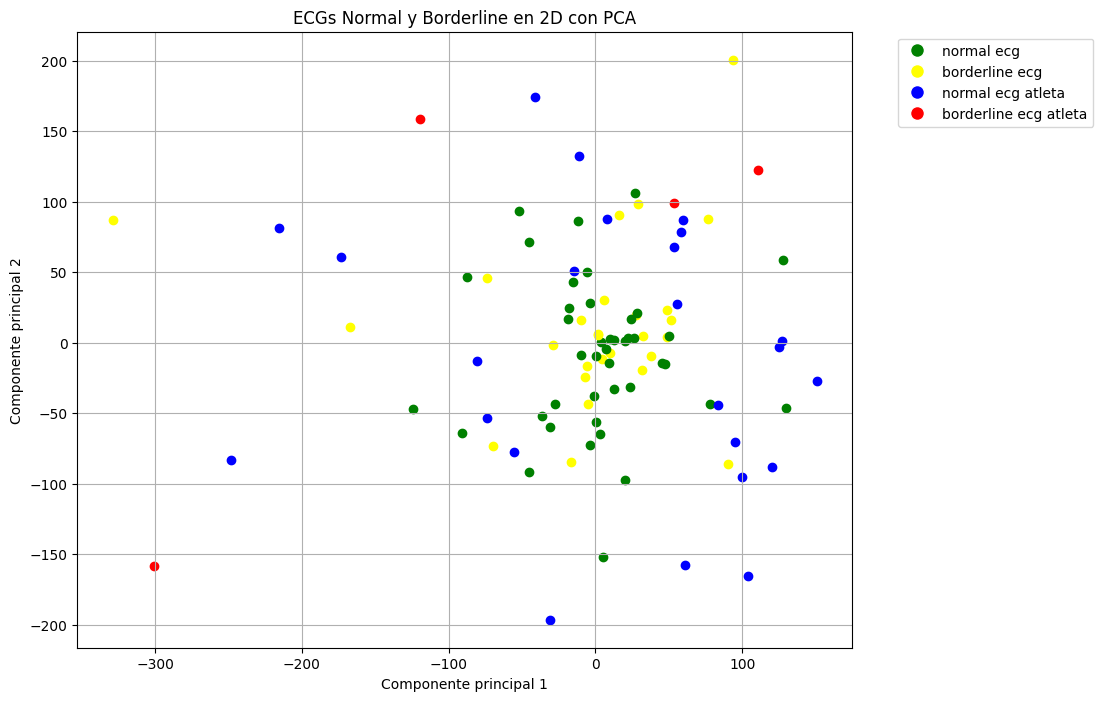

In [46]:
# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Clasificar los ECGs de los atletas por etiquetas
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))

# Crear un mapa de colores para las etiquetas
# verde para normal y amarillo para borderline
label_color_map = {'normal ecg': 'green', 'borderline ecg': 'yellow'}

print(len(etiquetaRiesgo))
print(len(ECGs))


# Graficar cada punto para los ECGs
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgo[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='green', label='normal ecg' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='yellow', label='borderline ecg' if i == 0 else "")
        print(f"ECG {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologos[i]}")

# Graficar cada punto para los ECGs de los atletas
for i, (x, y) in enumerate(principal_componentsD):
    labels = etiquetaRiesgoDeportista[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='blue', label='normal ecg atleta' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='red', label='borderline ecg atleta' if i == 0 else "")
        print(f"ECG Atleta {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologosAtletas[i]}")

# Crear la leyenda para las 2 bases de datos
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='normal ecg'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='borderline ecg'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='normal ecg atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='borderline ecg atleta')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y Borderline en 2D con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()


In [56]:
# Convertir las etiquetas a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
reshaped_ECGs = [ecg.flatten() for ecg in ECGsFiltrados] # Reshape ECGs to 2D


# Dividir los datos en entrenamiento y prueba
senales_entrenamiento, senales_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(ECGsFiltrados, etiquetaRiesgo, test_size=0.15, random_state=42)

print(f"Datos de entrenamiento: {len(senales_entrenamiento)}")
for i in range(len(senales_entrenamiento)):
    print(f"ECG {i} es {etiquetas_entrenamiento[i]}")

print(f"Datos de prueba: {len(senales_prueba)}")
for i in range(len(senales_prueba)):
    print(f"ECG {i} es {etiquetas_prueba[i]}")
    
print(f"Etiquetas de entrenamiento: {len(etiquetas_entrenamiento)}")
print(f"Etiquetas de prueba: {len(etiquetas_prueba)}")

Datos de entrenamiento: 58
ECG 0 es borderline ecg
ECG 1 es borderline ecg
ECG 2 es normal ecg
ECG 3 es normal ecg
ECG 4 es normal ecg
ECG 5 es borderline ecg
ECG 6 es borderline ecg
ECG 7 es borderline ecg
ECG 8 es borderline ecg
ECG 9 es borderline ecg
ECG 10 es normal ecg
ECG 11 es borderline ecg
ECG 12 es normal ecg
ECG 13 es borderline ecg
ECG 14 es normal ecg
ECG 15 es normal ecg
ECG 16 es normal ecg
ECG 17 es normal ecg
ECG 18 es normal ecg
ECG 19 es normal ecg
ECG 20 es normal ecg
ECG 21 es normal ecg
ECG 22 es normal ecg
ECG 23 es normal ecg
ECG 24 es borderline ecg
ECG 25 es normal ecg
ECG 26 es normal ecg
ECG 27 es borderline ecg
ECG 28 es borderline ecg
ECG 29 es borderline ecg
ECG 30 es normal ecg
ECG 31 es normal ecg
ECG 32 es normal ecg
ECG 33 es borderline ecg
ECG 34 es normal ecg
ECG 35 es normal ecg
ECG 36 es normal ecg
ECG 37 es normal ecg
ECG 38 es borderline ecg
ECG 39 es normal ecg
ECG 40 es normal ecg
ECG 41 es borderline ecg
ECG 42 es normal ecg
ECG 43 es normal

In [57]:



#claificador con GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Construir el modelo
model = Sequential()

# Agregar una capa GRU con 32 unidades
model.add(GRU(32, input_shape=(None, 1)))

# Agregar una capa densa con 1 unidad
model.add(Dense(1))

# Compilar el modelo
# Encode labels to numerical values
etiquetas_entrenamiento = label_encoder.fit_transform(etiquetas_entrenamiento)

# Reshape the input data to match the labels
senales_entrenamiento = np.array([ecg.reshape(-1, 1) for ecg in senales_entrenamiento])
senales_prueba = np.array([ecg.reshape(-1, 1) for ecg in senales_prueba])

etiquetas_prueba = label_encoder.transform(etiquetas_prueba)


model.compile(optimizer='adam', loss='mse')

# Convertir etiquetas_entrenamiento a un array de NumPy
etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)

# Entrenar el modelo
model.fit(senales_entrenamiento, etiquetas_entrenamiento, epochs=10, batch_size=32)

# Predecir las etiquetas de los atletas
precision = model.evaluate(senales_prueba, etiquetas_prueba)

print(f"Precisión: {precision}")
print(f"Etiquetas de prueba: {len(etiquetas_prueba)}")



Epoch 1/10


c:\Users\yanko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step - loss: 0.5735
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - loss: 0.4671
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - loss: 0.4316
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - loss: 0.3901
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step - loss: 0.3471
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 15s/step - loss: 0.3114
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 15s/step - loss: 0.2945
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 18s/step - loss: 0.2604
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 11s/step - loss: 0.2421
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step - loss: 0.2339
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2802
Precisión: 0.2801908254623413
Etiquetas de prueba: 11


ECG 0 es 0
ECG 1 es 0
ECG 2 es 1
ECG 3 es 1
ECG 4 es 0
ECG 5 es 1
ECG 6 es 0
ECG 7 es 1
ECG 8 es 1
ECG 9 es 0
ECG 10 es 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
ECG 0 es borderline ecg
ECG 1 es borderline ecg
ECG 2 es borderline ecg
ECG 3 es borderline ecg
ECG 4 es borderline ecg
ECG 5 es borderline ecg
ECG 6 es borderline ecg
ECG 7 es borderline ecg
ECG 8 es borderline ecg
ECG 9 es borderline ecg
ECG 10 es borderline ecg
Precisión: 0.0


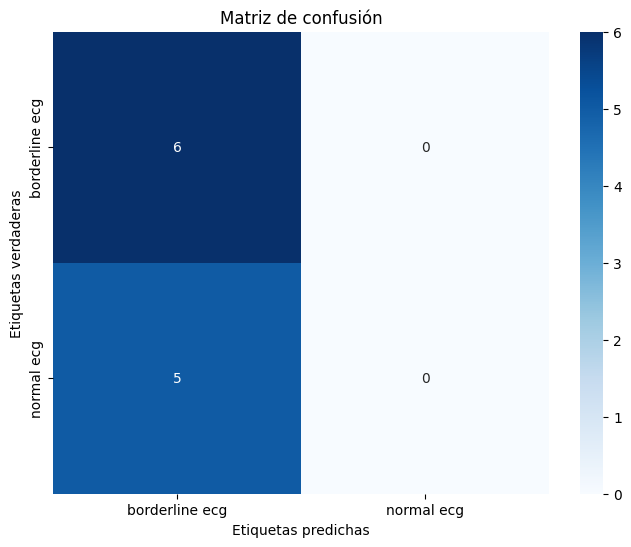

In [59]:
#predecir etiquetas de los atletas
#%pip install seaborn

for i in range(len(etiquetas_prueba)):
    print(f"ECG {i} es {etiquetas_prueba[i]}")
# Predecir las etiquetas de los atletas
ECGsPrueba_reshaped = np.array([ecg.reshape(-1, 1) for ecg in senales_prueba])

etiquetas_predichas = model.predict(ECGsPrueba_reshaped)

# Convertir las etiquetas predichas a valores categóricos
etiquetas_predichas = label_encoder.inverse_transform(etiquetas_predichas.flatten().astype(int))

for i in range(len(etiquetas_predichas)):
    print(f"ECG {i} es {etiquetas_predichas[i]}")

# Calcular la precisión
precision = accuracy_score(etiquetas_prueba, etiquetas_predichas)

print(f"Precisión: {precision}")

#graficar las etiquetas predichas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convertir etiquetas_prueba a valores categóricos
etiquetas_prueba_str = label_encoder.inverse_transform(etiquetas_prueba)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(etiquetas_prueba_str, etiquetas_predichas)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de confusión')
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.show()



In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Convertir las señales a la forma adecuada (samples, timesteps, features)
x = np.array(ECGsFiltrados).reshape(len(ECGsFiltrados), -1)  # Convertir a array y aplanar las señales de ECG

# Convertir las etiquetas a un formato binarizado
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(etiquestasCardiologos)

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform([str(label) for label in y])  

    

# Dividir en entrenamiento y pruebas
senales_entrenamiento, senales_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(x, y_encoded, test_size=0.2, random_state=42)


#Clasificador con GRU
#%pip install tensorflow
#%pip install setuptools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Construir el modelo
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(senales_entrenamiento.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))  # Usar sigmoide para múltiples salidas (multilabel)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convertir etiquetas de entrenamiento y prueba a formato binarizado
etiquetas_entrenamiento_bin = mlb.transform(etiquestasCardiologos[:len(senales_entrenamiento)])
etiquetas_prueba_bin = mlb.transform(etiquestasCardiologos[len(senales_entrenamiento):])

# Entrenar el modelo
model.fit(senales_entrenamiento, etiquetas_entrenamiento_bin, epochs=10, batch_size=32)

# Evaluar el modelo
perdida, precision = model.evaluate(senales_prueba, etiquetas_prueba_bin)

print(f"Pérdida: {perdida}")
print(f"Precisión: {precision}")

Epoch 1/10


c:\Users\yanko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0000e+00 - loss: 1.5384
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0000e+00 - loss: 2.6202
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0000e+00 - loss: 2.0405
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.0000e+00 - loss: 2.2688
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.0000e+00 - loss: 1.5032
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0000e+00 - loss: 1.3956
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 1.3062
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5667 - loss: 0.8761
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5771 - loss: 0.7558
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5979 - loss: 0.6944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8571 - loss: 0.5711
Pérdida: 0.5711129903793335
Precisión: 0.8571428656578064


In [51]:
# Predecir las etiquetas de los atletas
etiquetas_atletas_bin = mlb.transform(etiquestasCardiologosAtletas)
ECGsAtletas_reshaped = np.array([ecg.flatten() for ecg in ECGsAtletas])  # Reshape ECGsAtletas
perdida_atletas, precision_atletas = model.evaluate(ECGsAtletas_reshaped, etiquetas_atletas_bin)

print(f"Pérdida de los atletas: {perdida_atletas}")
print(f"Precisión de los atletas: {precision_atletas}")

# Predecir las etiquetas de los atletas
etiquetas_predichas_atletas = model.predict(ECGsAtletas_reshaped)

# Binarize the predicted labels
etiquetas_predichas_atletas = (etiquetas_predichas_atletas > 0.5).astype(int)

# Convertir las etiquetas predichas a valores categóricos
etiquetas_predichas_atletas = mlb.inverse_transform(etiquetas_predichas_atletas)

for i in range(len(etiquetas_predichas_atletas)):
    print(f"ECG {i} es {etiquetas_predichas_atletas[i]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 1.4820
Pérdida de los atletas: 1.4820295572280884
Precisión de los atletas: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ECG 0 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 1 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 2 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 3 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 4 es ('normal axis', 'sinus rhythm')
ECG 5 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 6 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 7 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 8 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 9 es ('normal axis', 'sinus rhythm')
ECG 10 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 11 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 12 es ('left axis deviation', 'normal axis', 'sinus rhythm')
ECG 13 es ('left axis de

c:\Users\yanko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['borderline ecg', 'first degree av block', 'left atrial enlargement', 'misplaced electrodes', 'normal ecg', 'normal sinus rhythm', 'possible left ventricular hypertrophy'] will be ignored
  warnings.warn(
